# Poshmark Brand Web Scraper

----

### Author: Lauran Ando
### Date: August 14, 2022

----

#### Project Purpose: 

Gather ecommerce data from Poshmark.com for a specific brand. Stores data in a csv file in Google Drive. 

----

Link: https://colab.research.google.com/drive/1RbDZRv9jKyzI1RyFak0Jekzpsk_9CePR?usp=sharing 

# FIRST STEP - SCRAPE BRAND DATA FROM POSHMARK AND STORE RESULTS IN GOOGLE DRIVE AS CSV.







In [21]:
import pandas as pd
import requests
import json
import time
import random
import base64
from IPython.display import display, HTML
from datetime import date
import numpy as np
from pandas.io.json import json_normalize
import re
import os
import matplotlib

In [22]:
# This has to be the Poshmark URL version of the brand name, also know as the brand tag.
# You can find the Poshmark brand_tag of the brand name by searching Poshmark for the brand here:
# https://poshmark.com/brands/
# Then when clicking on the brand, you can find the brand_tag at the end of the link:
# https://poshmark.com/brand/Vivienne_Westwood
# Vivienne Westwood = Vivienne_Westwood

brand_tag = "Vivienne_Westwood"

In [ ]:
# Web Scrape the data from Poshmark
# Store data in Pandas Dataframe

from google.colab import drive, files
from urllib.request import urlopen
from urllib.parse import urlparse
drive.flush_and_unmount()
drive.mount('/content/drive')



def PoshmarkBrandScraper(brand_tag):

  # pd.set_option('display.max_columns', 100)

  url_start = "https://poshmark.com"
  url_2 = "/vm-rest/channel_groups/brand/channels/" + brand_tag
  url_postrequest = "/collections/post?request={%22filters%22:"
  url_json_start = "{%22brand%22:[%22" + brand_tag + "%22],"
  url_inventory = "%22inventory_status%22:[%22" + "all" + "%22]},"
  url_facets = "%22facets%22:[%22color%22,%22department%22],%22experience%22:%22all%22,%22sizeSystem%22:%22us%22,"
  url_tail = "%22count%22:%2248%22}&summarize=true&pm_version=209.0.0"

  start_url = url_start + url_2 + url_postrequest + url_json_start + url_inventory + url_facets + url_tail

  MIN_SLEEP_TIME = 1
  page = 1


  def get_table_from_url(url):
    payload={}
    headers = {
      'authority': 'poshmark.com',
      'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
      'accept-language': 'en-US,en;q=0.9,ja;q=0.8',
      'cache-control': 'max-age=0',
      'if-none-match': 'W/"98bcb-l0mGc5jkSNCN+QgJpGNYW261QjY"',
      'sec-ch-ua': '"Chromium";v="104", " Not A;Brand";v="99", "Google Chrome";v="104"',
      'sec-ch-ua-mobile': '?0',
      'sec-ch-ua-platform': '"macOS"',
      'sec-fetch-dest': 'document',
      'sec-fetch-mode': 'navigate',
      'sec-fetch-site': 'none',
      'sec-fetch-user': '?1',
      'upgrade-insecure-requests': '1',
      'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'
    }

    response = requests.request("GET", url, headers=headers, data=payload)

    if response.status_code != 200:
        print("Couldn't Connect to Poshmark")
    else:
        # print("success")
        text = response.text
        nested_text = json.loads(text)
        # print(nested_text)
        if "statusCode" in nested_text:
            if nested_text["statusCode"] == 404:
                print("Couldn't find Poshmark Brand")
        elif "data" in nested_text:
            df = pd.json_normalize(nested_text['data'])
            # total_items = more_data['total']
            try:
                if 'more' in nested_text:
                    more_data = nested_text['more']
                    if "next_max_id" in more_data:
                        NewMaxID = str(more_data['next_max_id'])
                        url_nextmax = "%22max_id%22:%22" + NewMaxID + "%22,"
                        new_url = url_start + url_2 + url_postrequest + url_json_start + url_inventory + url_facets + url_nextmax + url_tail
                    else:
                        new_url = "end"
                else:
                    new_url = "end"
            except:
                new_url = "end"

            return df, new_url
  try:
    brand_df, next_url = get_table_from_url(start_url)
    if brand_df.size > 0:
      # print("Table Size: ",brand_df.size)
      while next_url != "end":
          print(" Scraping page: ", str(page), " of ", brand_tag, ". ", str(brand_df.shape[0]), ' items information collected')
          table_to_add, next_url = get_table_from_url(next_url)
          brand_df = pd.concat([brand_df, table_to_add])
          sleep_time = MIN_SLEEP_TIME + random.random() * 10
          time.sleep(int(sleep_time))
          page = page + 1
      # print(brand_df.head(10))
      print("Scrape Complete. Scraped ",str(brand_df.shape[0])," items.")
      return brand_df
    else:
      print("No brand data collected")
      return None
  except Exception as e: print(e)

  

brand_info = PoshmarkBrandScraper(brand_tag)


In [ ]:
# Save Pandas Dataframe as CSV file to Google Drive

from datetime import datetime
from google.colab import drive, files
from urllib.request import urlopen
from urllib.parse import urlparse
drive.flush_and_unmount()
drive.mount('/content/drive')

def download_csv_to_google_drive(df):
  output_directory = "/content/drive/My Drive/Poshmark_Brands"
  user_dir = output_directory + '/' + brand_tag
  now = datetime.now()
  date_time = now.strftime("%Y%d%m_%H%M%S")
  csv_filename = user_dir + "/" + brand_tag + ".csv"
  if not os.path.isfile(user_dir):
    os.makedirs(user_dir, exist_ok=True)
  df.to_csv(csv_filename,index=False)
  print("Saved to Google Drive")
try:
    download_csv_to_google_drive(df=brand_info)
    drive.flush_and_unmount()

except Exception as e: 
    print(e)
    drive.flush_and_unmount()

Mounted at /content/drive
Saved to Google Drive


In [ ]:
# Test data frame is correctly populated with data
brand_info[['title', 'creator_username', 'price', 'inventory.status','share_count', 'like_count','brand','catalog.department_obj.slug','category','category_v2.slug','first_available_at','status_changed_at']].head(10)

# ALTERNATE FIRST STEP - UPLOAD CSV FROM HARD DRIVE.






In [ ]:
import pandas as pd
import requests
import json
import time
import random
import base64
from IPython.display import display, HTML
from datetime import date
import numpy as np
from pandas.io.json import json_normalize
import re
import os
import matplotlib

# This has to be the Poshmark URL version of the brand name, also know as the brand tag.
# You can find the Poshmark brand_tag of the brand name by searching Poshmark for the brand here:
# https://poshmark.com/brands/
# Then when clicking on the brand, you can find the brand_tag at the end of the link:
# https://poshmark.com/brand/Vivienne_Westwood
# Vivienne Westwood = Vivienne_Westwood

brand_tag = "Vivienne_Westwood"

# This step allows you to manually upload a Poshmark Brand CSV file.
# Useful if you have previously scraped the data and saved the CSV file to your desktop and do not want to run a new scrape.

# NOTE - ONLY WORKS WITH SMALL SIZED CSV FILES LESS THAN 10MB
# If uploading a large CSV file, use Google Drive import (see next block)

from google.colab import files
import io

uploaded = files.upload()
print(uploaded)
brand_info = pd.read_csv(io.BytesIO(uploaded[f"{brand_tag}.csv"]))

# Test uploaded CSV correctly populated Dataframe
brand_info[['title', 'creator_username', 'price', 'inventory.status','share_count', 'like_count','brand','catalog.department_obj.slug','category','category_v2.slug','first_available_at','status_changed_at']].head(10)

# ALTERNATE FIRST STEP - IMPORT CSV STORED IN GOOGLE DRIVE.







In [1]:
import pandas as pd
import requests
import json
import time
import random
import base64
from IPython.display import display, HTML
from datetime import date
import numpy as np
from pandas.io.json import json_normalize
import re
import os
import matplotlib

# This has to be the Poshmark URL version of the brand name, also know as the brand tag.
# You can find the Poshmark brand_tag of the brand name by searching Poshmark for the brand here:
# https://poshmark.com/brands/
# Then when clicking on the brand, you can find the brand_tag at the end of the link:
# https://poshmark.com/brand/Vivienne_Westwood
# Vivienne Westwood = Vivienne_Westwood

brand_tag = "Vivienne_Westwood"


# Import CSV stored in Google Drive if you want to restore previously scraped data.
# Note - Useful for importing large (10mb+ CSV files) that are too large to import via manual upload (above). 
from google.colab import drive 
drive.mount('/content/gdrive')

# Assuming the brand tag and save location did not change from when running scraper
brand_info = pd.read_csv(f'/content/gdrive/MyDrive/Poshmark_Brands/{brand_tag}/{brand_tag}.csv')

# Test imported data was succesful:
brand_info[['title', 'creator_username', 'price', 'inventory.status','share_count', 'like_count','brand','catalog.department_obj.slug','category','category_v2.slug','first_available_at','status_changed_at']].head(5)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (134,137,139,140) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,title,creator_username,price,inventory.status,share_count,like_count,brand,catalog.department_obj.slug,category,category_v2.slug,first_available_at,status_changed_at
0,Vivienne Westwood Man 3Button Collar Shirt…,sauvagebeauty,175,sold_out,13,5,Vivienne Westwood,Men,Other,Shirts,2021-12-14T05:04:04-08:00,2021-12-14T05:04:05-08:00
1,NIB VIVIENNE WESTWOOD PURPLE PUMPS,joydubay,89,available,397,24,Vivienne Westwood,Women,Shoes,Shoes,2022-05-31T21:56:00-07:00,2022-05-31T21:56:01-07:00
2,Vivienne Westwood Wallet Purse Orb Grey Black ...,bagzposher,603,available,10,4,Vivienne Westwood,Women,Handbags,Bags,2022-05-09T02:22:09-07:00,2022-05-09T02:22:09-07:00
3,VIVIENNE WESTWOOD Anglomania LS Blouse Size 42,sauvagebeauty,166,available,3,5,Vivienne Westwood,Women,Tops,Tops,2022-07-23T20:50:18-07:00,2022-07-23T20:50:18-07:00
4,Worlds End John Bull hat,wardrobefantasy,206,available,29,11,Vivienne Westwood,Men,Other,Accessories,2022-08-06T14:34:10-07:00,2022-08-12T10:07:53-07:00


# CHECK DATA IS CORRECTLY UPLOADED FOR ANALYSIS

In [35]:
# VIEW TOP 10 SOLD ITEMS SORTED BY PRICE

# Taking notes from https://www.kaggle.com/code/aremoto/retail-sales-forecast

brand_info.rename(columns = {'inventory.status':'stock_status', 'category_v2.slug':'subcategory','catalog.department_obj.slug':'gender','inventory.size_quantity_revision':'quantity'}, inplace = True)

brand_info["status_changed_at"] = pd.to_datetime(brand_info["status_changed_at"], utc=True)
brand_info["first_available_at"] = pd.to_datetime(brand_info["first_available_at"], utc=True)

sales = brand_info[brand_info['stock_status'] == "sold_out"]
sales = sales.sort_values(by=['price'], ascending=False)
sales[['title','price','subcategory','status_changed_at']].head(10)

,title,price,subcategory,status_changed_at
2470,Vivienne Westwood F/W 1992 Rare Always On Came...,2700,Tops,2022-05-26 07:23:05+00:00
2363,Vivienne Westwood F/W 1992 Rare Always On Came...,2700,Tops,2022-06-14 15:37:31+00:00
3287,Vivienne Westwood Spring 1994 Café Society Leo...,1800,Tops,2022-03-22 03:57:48+00:00
4136,NWT Vivienne Westwood Dame Corset Dress 8UK,1500,Dresses,2021-09-05 21:54:07+00:00
2508,Vivienne Westwood corset top,1440,Tops,2021-02-07 19:46:59+00:00
4409,Vivienne Westwood Wool Ruffled Panels Skirt w/...,1200,Skirts,2022-01-17 00:53:46+00:00
4432,Vivienne Westwood NWT Archive Orb Yasmine,1200,Bags,2022-01-16 22:25:27+00:00
3685,Rare Vivienne Westwood corset,1200,Tops,2022-03-12 16:47:02+00:00
4919,Beautiful Vivienne Westwood black feather corset,1200,Tops,2021-12-06 18:57:45+00:00
4255,Vivienne Westwood 1997 draped dress,1100,Dresses,2022-01-26 13:26:59+00:00


# DESCRIBE DATA OF SOLD AND AVAILABLE ITEMS - (CAN SKIP THIS STEP)



In [25]:
brand_info_reduced_cols = brand_info[['price','original_price_amount.val','comment_count','like_count','share_count','stock_status']]
brand_info_reduced_cols[brand_info_reduced_cols['stock_status'] == 'sold_out'].describe()

,price,original_price_amount.val,comment_count,like_count,share_count
count,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000
mean,113.629416,293.164363,1.663210,23.646313,20.322965
std,136.646982,677.591698,3.187063,28.697926,79.379081
min,3.000000,-2.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,0.000000,6.000000,2.000000
50%,85.000000,177.000000,0.000000,15.000000,5.000000
75%,128.000000,350.000000,2.000000,31.000000,14.000000
max,2700.000000,10000.000000,62.000000,407.000000,2287.000000


In [26]:
brand_info_reduced_cols = brand_info[['price','original_price_amount.val','comment_count','like_count','share_count','stock_status']]
brand_info_reduced_cols[brand_info_reduced_cols['stock_status'] == 'available'].describe()

,price,original_price_amount.val,comment_count,like_count,share_count
count,2023.000000,2023.000000,2023.000000,2023.000000,2023.000000
mean,320.773109,520.646565,1.090460,32.391003,31.581809
std,695.171164,1053.243535,2.572821,43.470818,100.775176
min,8.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,0.000000,0.000000,10.000000,4.000000
50%,175.000000,280.000000,0.000000,20.000000,10.000000
75%,300.000000,640.000000,1.000000,42.000000,20.000000
max,10000.000000,14400.000000,32.000000,1211.000000,2333.000000


# TOP CATEGORY BY SALES QUANTITY

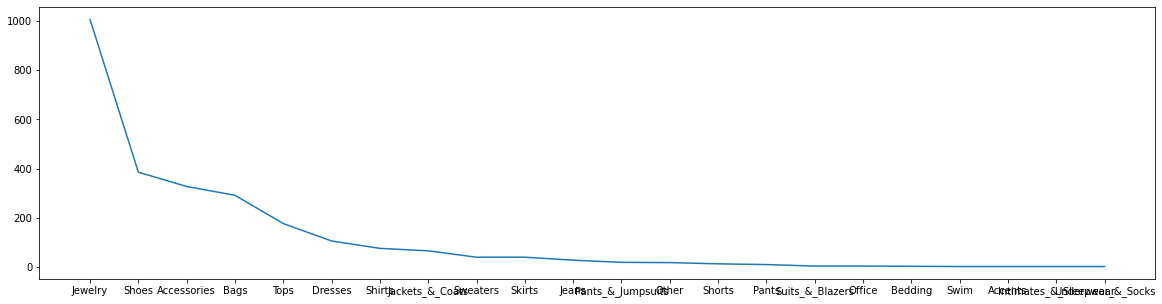

In [36]:
from matplotlib import pyplot as plt
sales_df = brand_info[brand_info['stock_status'] == 'sold_out']
sales_df_top_categories = sales_df.groupby('subcategory').agg({'subcategory':'size', 'price':'mean'}).rename(columns={'subcategory':'Sales','price':'Average_Sale_Price'}).reset_index()
sorted_sales_df = sales_df_top_categories.sort_values('Sales', ascending=False)
plt.figure(figsize=(20,5))
plt.plot(sorted_sales_df.subcategory,sorted_sales_df.Sales)
plt.show()

In [37]:
sales_df = brand_info[brand_info['stock_status'] == 'sold_out']
sales_df_top_categories = sales_df.groupby('subcategory').agg({'subcategory':'size', 'price':'mean'}).rename(columns={'subcategory':'Sales','price':'Average_Sold_Listing_Price'}).reset_index()
#sales_df_top_categories.sort_values('Sales', ascending=False)

unsold_df = brand_info[brand_info['stock_status'] == 'available']
unsold_df_top_categories = unsold_df.groupby('subcategory').agg({'subcategory':'size', 'price':'mean'}).rename(columns={'subcategory':'Unsold_Listings','price':'Average_Unsold_Listing_Price'}).reset_index()
#unsold_df_top_categories.sort_values('Unsold_Listings', ascending=False)

compare_list_price_df = pd.merge(sales_df_top_categories, unsold_df_top_categories, on='subcategory')
compare_list_price_df.sort_values('Sales', ascending=False)

,subcategory,Sales,Average_Sold_Listing_Price,Unsold_Listings,Average_Unsold_Listing_Price
8,Jewelry,1007,99.728898,382,192.089005
13,Shoes,385,84.457143,325,238.646154
1,Accessories,327,75.571865,250,182.104000
2,Bags,291,170.371134,273,437.831502
19,Tops,176,167.437500,173,510.387283
4,Dresses,105,184.485714,156,500.115385
12,Shirts,75,94.026667,62,460.177419
6,Jackets_&_Coats,65,193.538462,113,478.123894
17,Sweaters,39,120.589744,44,546.340909
15,Skirts,39,153.410256,100,270.690000


# SALES OVER TIME

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


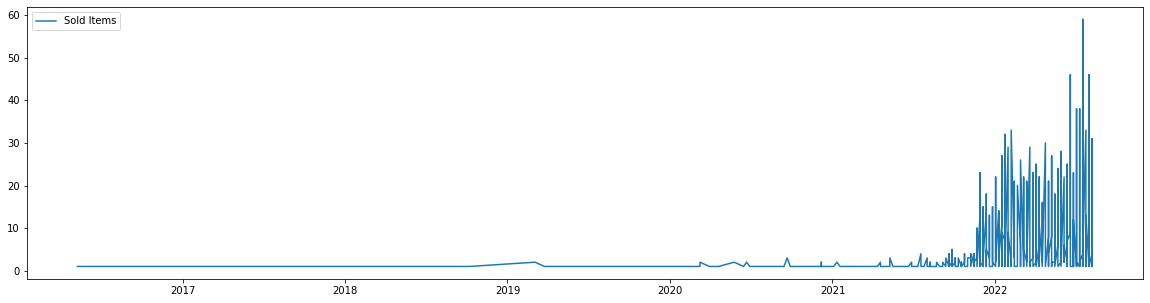

In [56]:
from matplotlib import pyplot as plt

brand_info['units'] = brand_info.groupby('id')['id'].transform('count')
weekly_sales_df = brand_info[brand_info['stock_status'] == 'sold_out']

weekly_sales_df['Week'] = pd.to_datetime(weekly_sales_df['status_changed_at']) - pd.to_timedelta(7, unit='d')
weekly_sales_df = weekly_sales_df.groupby(['subcategory', pd.Grouper(key='Week', freq='W-MON')])['units'].sum().reset_index().sort_values('Week')
weekly_avg_sales_df = weekly_sales_df.sort_values('Week', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(weekly_avg_sales_df.Week,weekly_avg_sales_df.units)
plt.legend(['Sold Items'])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


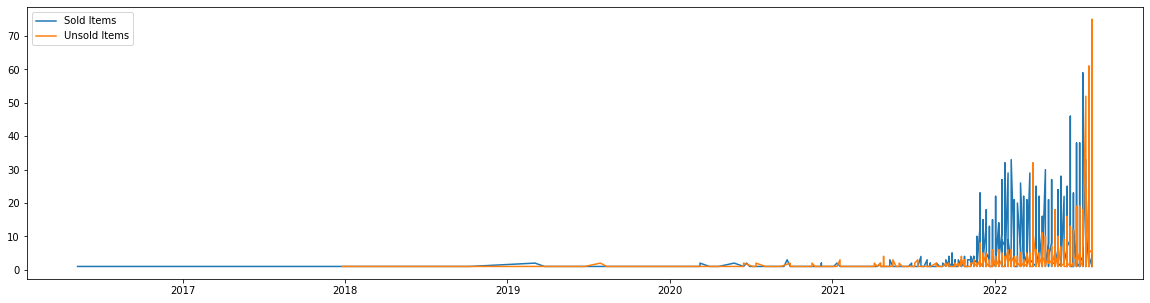

In [55]:
from matplotlib import pyplot as plt

brand_info['units'] = brand_info.groupby('id')['id'].transform('count')
weekly_unsold_df = brand_info[brand_info['stock_status'] == 'available']

weekly_unsold_df['Week'] = pd.to_datetime(weekly_unsold_df['status_changed_at']) - pd.to_timedelta(7, unit='d')
weekly_unsold_df = weekly_unsold_df.groupby(['subcategory', pd.Grouper(key='Week', freq='W-MON')])['units'].sum().reset_index().sort_values('Week')
weekly_avg_unsold_df = weekly_unsold_df.sort_values('Week', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(weekly_avg_sales_df.Week,weekly_avg_sales_df.units)
plt.plot(weekly_avg_unsold_df.Week,weekly_avg_unsold_df.units)
plt.legend(['Sold Items', 'Unsold Items'])
plt.show()

# SHARES, LIKES, COMMENTS OVER TIME - ALL ITEMS

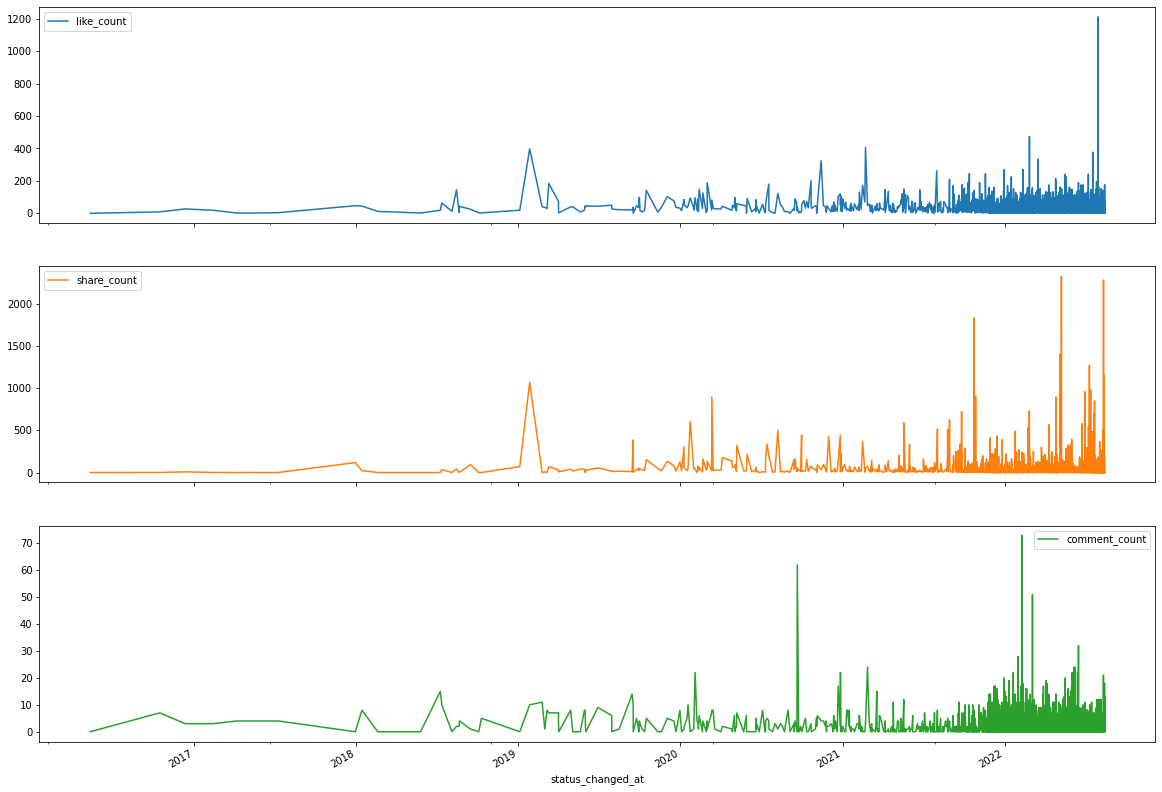

In [67]:
from matplotlib import pyplot as plt

brand_info[['status_changed_at','like_count','share_count','comment_count']].plot(x='status_changed_at', subplots=True, figsize=(20,15))
plt.show()



In [70]:
sales_df = brand_info[brand_info['stock_status'] == 'sold_out']
sales_df_top_community_engagement = sales_df.groupby('subcategory').agg({'subcategory':'size', 'like_count':'median','share_count':'median','comment_count':'median'}).rename(columns={'subcategory':'Sales','like_count':'Median Likes','share_count':'Median Shares','comment_count':'Median Comments'}).reset_index()
#sales_df_top_categories.sort_values('Sales', ascending=False)

unsold_df = brand_info[brand_info['stock_status'] == 'available']
unsold_df_top_community_engagement = unsold_df.groupby('subcategory').agg({'subcategory':'size', 'like_count':'median','share_count':'median','comment_count':'median'}).rename(columns={'subcategory':'Unsold_Listings','like_count':'Median Likes','share_count':'Median Shares','comment_count':'Median Comments'}).reset_index()
#unsold_df_top_categories.sort_values('Unsold_Listings', ascending=False)

compare_engagement_df = pd.merge(sales_df_top_community_engagement, unsold_df_top_community_engagement, on='subcategory')
compare_engagement_df.sort_values('Sales', ascending=False)

,subcategory,Sales,Median Likes_x,Median Shares_x,Median Comments_x,Unsold_Listings,Median Likes_y,Median Shares_y,Median Comments_y
8,Jewelry,1007,15.0,4.0,0.0,382,29.0,6.0,0.0
13,Shoes,385,10.0,7.0,0.0,325,16.0,11.0,0.0
1,Accessories,327,15.0,4.0,0.0,250,29.0,7.0,0.0
2,Bags,291,24.0,8.0,2.0,273,30.0,14.0,0.0
19,Tops,176,15.0,5.0,0.0,173,17.0,10.0,0.0
4,Dresses,105,15.0,11.0,1.0,156,14.0,11.0,0.0
12,Shirts,75,10.0,5.0,0.0,62,14.5,8.5,0.0
6,Jackets_&_Coats,65,12.0,8.0,0.0,113,18.0,10.0,0.0
17,Sweaters,39,16.0,6.0,0.0,44,23.0,13.5,0.0
15,Skirts,39,16.0,8.0,0.0,100,17.0,10.0,0.0
